# Recurrent Neural Networks
## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set up the use of GPU or CPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
# path to save results and read hyper-param values
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Model Input

count    1259.000000
mean        0.473722
std         0.261378
min         0.000000
25%         0.237076
50%         0.405844
75%         0.700048
max         1.000000
dtype: float64

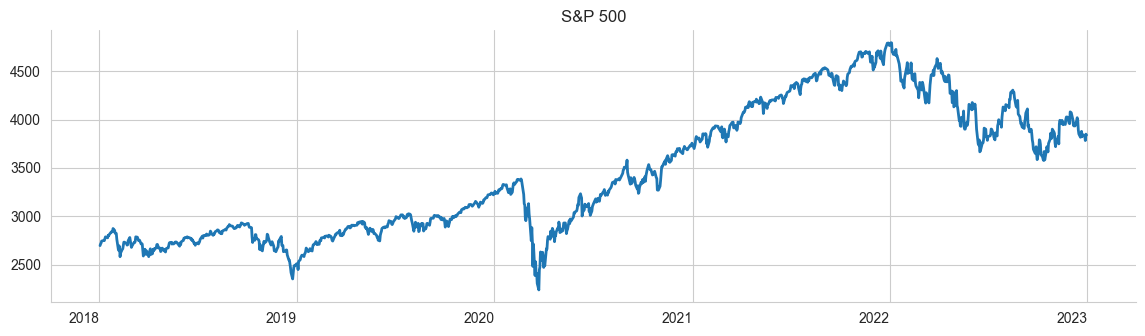

In [6]:
# Download SP500 data from FRED: https://fred.stlouisfed.org/
sp500 = web.DataReader('SP500', 'fred', start='2018', end='2023').dropna()
# sp500.tail()
ax = sp500.plot(title='S&P 500', legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

# Preprocessing raw data using min-max scaler
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.head()
sp500_scaled.describe()

### Model Processing 

Our model input is a time series (i.e., a sequence of numbers indexed by time):

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we adopt the rolling-window approach to make one-day ahead forecast.

For each window, We take 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each. We obtain input-output pairs as shown in the following table:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_{1},x_{2},x_{3},x_{4},x_{5},\ldots,x_{63}\rangle} & { x_{64}} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6}\ldots,x_{64}\rangle } & {x_{65} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-63},\ldots,x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

In our example, we take SP500 daily data from January 2018 to December 2022  
- The first window takes the input from 2018-01-02 to 2018-04-03 (63 trading days) to predict 2018-0404. 
- The second window takes the input from Jan 3 2018 to Apr 4, 2018 to predict  Apr 5, 2018.
- The iteration continues and traverses 1196 rolling windows...
- The second to last iteration takes the input from from Sep 29, 2022 to December 28, 2022, to predict December 29, 2022. 
- The last iteration takes the input from Sep 30, 2022 to December 29, 2022, to predict December 30, 2022. 

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [7]:
def create_univariate_rnn_data(data, window_size):
    n = len(data) # sp500_scaled: 1259 x 1 and n = 1259
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


window_size = 63
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)
# print(X.shape) # vs. sp500_scaled: 1259 x 1
# print(X)

# Interpretation
# instead of writing a loop, I reorganize the time-series data into a panel. Each row (DATE) corresponds to the out-of-sample forecast to be made by each rolling window.   
# To forecast SP500 on 2018-04-04, we use data with key from 0 to 62. These data are the SP500 observed in the first 63 trading days in sp500_scaled.

We apply this function to the rescaled stock index for a window_size=63 to obtain a panel data (two-dimensional dataset) with size:<br> 
number of samples x number of timesteps.

**Train-test split** <br>
To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

In [8]:
X_train = X[:'2021'].values.reshape(-1, window_size, 1)
y_train = y[:'2021']
y_train.shape
# print(y_train)

n_obs, window_size, n_features = X_train.shape # (945, 63, 1)
# keep the last year for testing
X_test = X['2022':].values.reshape(-1, window_size, 1)
y_test = y['2022':] # 251 x 1

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN. We use Keras to quickly build a two hidden layer RNN of the following specifications <br>

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the general Keras documentation and the LSTM documentation in particular for examples of how to quickly use Keras to build neural network models. Make sure you are initializing your optimizer given the keras-recommended approach for RNNs.

In [9]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create model and train
rnn = create_RNN(hidden_units=3, dense_units=1, input_shape=(window_size,n_features), 
                   activation=['tanh', 'tanh'])
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

**Train the Model** <br>
We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [10]:
RNN_training = rnn.fit(X_train, 
                       y_train, 
                       epochs=100, 
                       batch_size=20,
                       validation_data=(X_test, y_test),
                       verbose=1)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

### Note
When training a Recurrent Neural Network (RNN), the epoch represents one iteration where: The entire training dataset (X_train, y_train) is passed through the model once in forward and backward passes. The model updates its weights at the end of the epoch using the computed gradients from the backward pass.

- epochs=100: The training loop will run 100 times over the entire dataset. This means the model will see and learn from the dataset 100 times, adjusting its internal weights after each pass.
- batch_size=20: This divides the dataset into batches of size 20. Instead of updating the weights after processing the entire dataset (which could be slow), the model updates its weights after processing each mini-batch of 20 samples.
- validation_data=(X_test, y_test): After each epoch, the model will evaluate its performance on the test set to monitor generalization.

In Summary: 1 epoch = The model processes all of the training data once. 100 epochs = The model processes the entire dataset 100 times, with weights being updated after each mini-batch of 20 samples. So in the above case, during the fit() method, the RNN will go through the entire X_train 100 times, updating its weights based on the error after processing each mini-batch. The validation data is used to assess performance after each epoch.

### Model Output

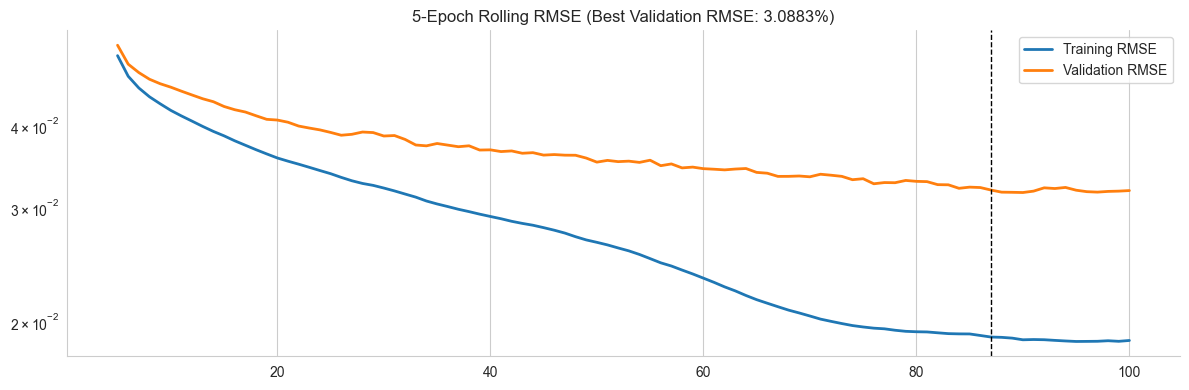

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(RNN_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300)

In [12]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0182 | Test RMSE (scaled): 0.0314


In [13]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train IC: 0.9953 | Test IC: 0.9614


**Rescale Predictions**

In [14]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [15]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 46.56 | Test RMSE: 80.33


In [16]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), 
                   test_predict.to_frame('predictions').assign(data='Test')])

sp500 = pd.merge(sp500, to_be_merged, how='inner', on = 'DATE')
# remove the suffixes brought by pd.merge()
sp500.columns = sp500.columns.str.rstrip('_x').str.rstrip('_y')

In [20]:
sp500

,SP500,Train Predictions,Test Predictions,predictions,data
DATE,,,,,
2018-04-04,2644.69,2540.163330,NaN,2540.163330,Train
2018-04-05,2662.84,2555.172852,NaN,2555.172852,Train
2018-04-06,2604.47,2579.299316,NaN,2579.299316,Train
2018-04-09,2613.16,2526.371826,NaN,2526.371826,Train
2018-04-10,2656.87,2558.838135,NaN,2558.838135,Train
...,...,...,...,...,...
2022-12-23,3844.82,NaN,3920.636230,3920.636230,Test
2022-12-27,3829.25,NaN,3935.109619,3935.109619,Test
2022-12-28,3783.22,NaN,3912.868408,3912.868408,Test


In [17]:
to_be_merged

,predictions,data
DATE,,
2018-04-04,2615.979736,Train
2018-04-05,2656.968262,Train
2018-04-06,2683.752686,Train
2018-04-09,2629.463135,Train
2018-04-10,2615.863281,Train
...,...,...
2022-12-23,3841.465820,Test
2022-12-27,3845.835449,Test
2022-12-28,3837.571045,Test


### Visualization

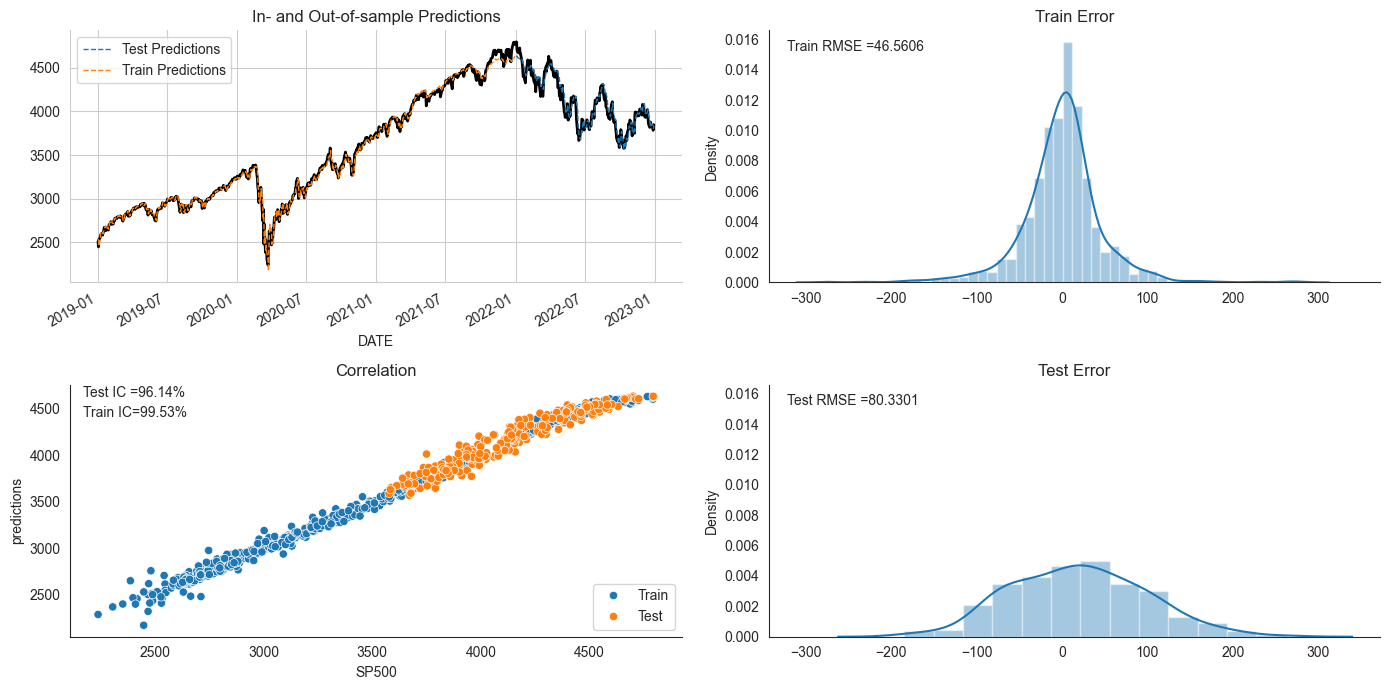

In [18]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['2019':, 'SP500'].plot(lw=2, ax=ax1, c='k')
sp500.loc['2019':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300)

The IC measures the rank correlation (typically using Spearman rank correlation) between the predicted values (e.g., model forecasts) and the actual observed values (e.g., returns). It indicates how well the predictions match the actual outcomes in terms of their rank order.<br>

**Interpretation:**
- IC = +1: Perfect positive rank correlation; the predictions are perfectly aligned with the actual outcomes.
- IC = 0: No correlation; predictions are no better than random guesses.
- IC = -1: Perfect negative rank correlation; the predictions are perfectly inversely related to the actual outcomes.
    
**Train and Test Information Coefficients**
- Train IC: This is the IC calculated on the training data, which measures how well the model's predictions fit the training data. A high Train IC suggests that the model is well fitted to the training data, but it does not necessarily indicate that the model generalizes well to unseen data.

- Test IC: This is the IC calculated on the test (or validation) data, which assesses the model's predictive power on unseen data. The Test IC is more critical for evaluating the model’s true predictive performance, as it shows how well the model generalizes.